In [1]:
import pandas as pd

In [2]:
df_feature = pd.read_parquet("s3://tech-challenge-3-models/feature-store/variables/variables.parquet")

In [3]:
df_feature[['player_id', 'days_unknown_injury','days_corona_virus','gamesmissed_unknown_injury','gamesmissed_corona_virus']].sort_values('days_corona_virus', ascending=False)

,player_id,days_unknown_injury,days_corona_virus,gamesmissed_unknown_injury,gamesmissed_corona_virus
1194,743591,0.0,44.0,0.0,13.0
939,614328,16.0,33.0,4.0,7.0
878,58345,13.0,31.0,2.0,0.0
1054,677512,0.0,26.0,0.0,3.0
247,111828,11.0,21.0,1.0,4.0
...,...,...,...,...,...
536,346923,186.0,0.0,26.0,0.0
535,346067,0.0,0.0,0.0,0.0
534,346065,0.0,0.0,0.0,0.0
533,345861,0.0,0.0,0.0,0.0


In [4]:
df_feature_test = df_feature.drop(columns=['player_id', 'days_unknown_injury','days_corona_virus','gamesmissed_unknown_injury','gamesmissed_corona_virus']) 

In [5]:
df_feature['target'].value_counts(normalize=True)*100

target
0.0    94.645081
1.0     5.354919
Name: proportion, dtype: float64

In [6]:
from sklearn.model_selection import train_test_split

X = df_feature_test.drop(columns='target')
y = df_feature_test['target']

In [7]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [8]:
y_resampled.value_counts(normalize=True)*100

target
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

scaler = MinMaxScaler()

pipeline = Pipeline([
    ('scaler', scaler)
])

pipeline.fit(x_train, y_train)

x_train_scaled = pipeline.fit_transform(x_train)
x_test_scaled = pipeline.fit_transform(x_test)

x_train_scaled = pd.DataFrame(x_train_scaled, columns=X.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=X.columns)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Definir os parâmetros a serem testados
param_grid = {
    'n_estimators': [20, 50, 100, 150, 200, 250, 300],
    'max_depth': [4, 8, 12, 16, 20, 24],
    'class_weight': ['balanced', 'balanced_subsample'],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
}

# Inicializar o classificador Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Realizar a busca em grade para encontrar os melhores parâmetros
grid_search = GridSearchCV(rf_classifier, param_grid, cv=10, scoring='accuracy')
grid_search.fit(x_train_scaled, y_train)

# Utilizar o modelo com os melhores parâmetros
best_rf_classifier = grid_search.best_estimator_

# Treinar o modelo com todos os dados de treinamento
best_rf_classifier.fit(x_train_scaled, y_train)

# Prever os rótulos para os dados de teste
y_pred = best_rf_classifier.predict(x_test)

scores = cross_val_score(best_rf_classifier, x_train_scaled, y_train, cv=10, scoring='accuracy')

print(scores)
print(best_rf_classifier)
print("Acurácia média com validação cruzada:", scores.mean())

KeyboardInterrupt: 

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

modelo_RFC_cv = RandomForestClassifier(class_weight='balanced',
                                       n_estimators= 200,
                                       max_depth= 8,
                                       random_state=42)

scores = cross_val_score(modelo_RFC_cv, x_train_scaled, y_train, cv=10, scoring='accuracy')

print(scores)
print("Acurácia média com validação cruzada:", scores.mean())

[0.96052632 0.94736842 0.95175439 0.94298246 0.94736842 0.93859649
 0.95614035 0.92982456 0.9122807  0.96491228]
Acurácia média com validação cruzada: 0.9451754385964912


              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94       380
         1.0       0.98      0.89      0.93       380

    accuracy                           0.94       760
   macro avg       0.94      0.94      0.94       760
weighted avg       0.94      0.94      0.94       760



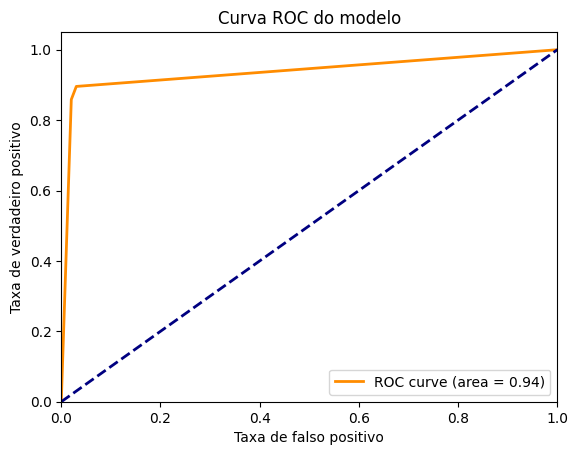

[[372   8]
 [ 40 340]]


In [12]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

modelo_RFC_cv.fit(x_train_scaled, y_train)

y_pred = modelo_RFC_cv.predict(x_test_scaled)

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)


fpr_smooth = np.linspace(fpr[0], fpr[-1], 100)
tpr_smooth = np.interp(fpr_smooth, fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr_smooth, tpr_smooth, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falso positivo')
plt.ylabel('Taxa de verdadeiro positivo')
plt.title('Curva ROC do modelo')
plt.legend(loc="lower right")
plt.show()

matriz = confusion_matrix(y_test, y_pred)
print(matriz)

<module 'matplotlib.pyplot' from '/home/leone-unix/tc_3/coleta-transfermarkt/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

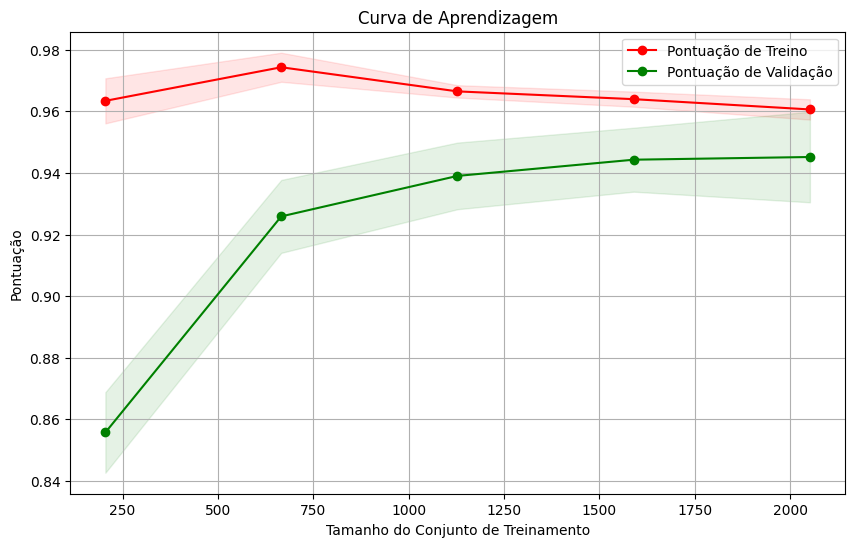

In [18]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Função para plotar a curva de aprendizagem
def plot_learning_curve(estimator, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title("Curva de Aprendizagem")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Tamanho do Conjunto de Treinamento")
    plt.ylabel("Pontuação")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Pontuação de Treino")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Pontuação de Validação")

    plt.legend(loc="best")
    return plt

     

plot_learning_curve(modelo_RFC_cv, x_train_scaled, y_train, cv=10)
     


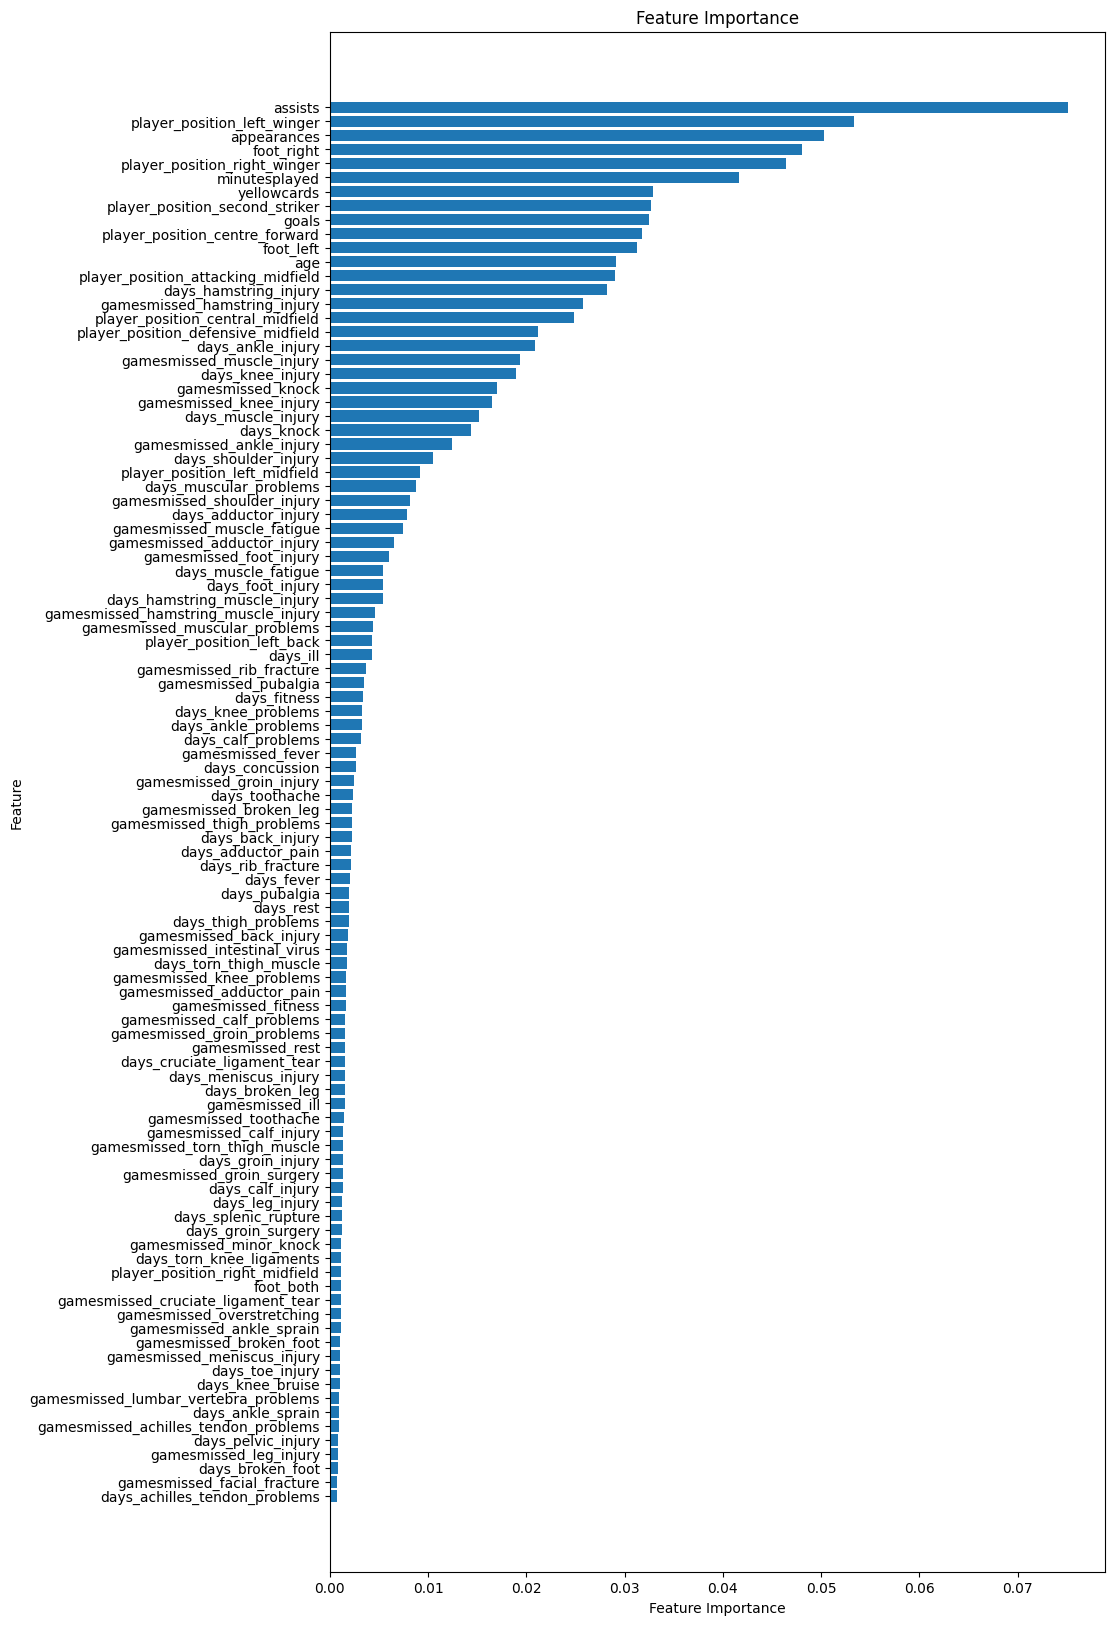

In [19]:
# Calcular importância das features
# Calcula a importância das features (atributos) usando um método chamado diminuição média da impureza para um modelo de Random Forest Classifier
feature_importance = modelo_RFC_cv.feature_importances_

# Plotar importância das features
plt.figure(figsize=(10, 20))
sorted_idx = np.argsort(feature_importance)[-100:]
features = df_feature_test.columns
plt.barh(features[sorted_idx], feature_importance[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()
